In [3]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
# reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
# reply = requests.get('https://gitlab.com/data.europa.eu/data-provider-repository/-/raw/master/dg-eac/2021.05.11%20KA3%20mobilities%20eligible%20finalised%20started%20in%202014-2019.csv?inline=false')
reply = requests.get('https://gitlab.com/data.europa.eu/data-provider-repository/-/raw/master/dg-eac/2021.05.11%20KA1%20mobilities%20eligible%20finalised%20started%20in%202018.csv?inline=false')
reply.encoding = 'utf-8'

In [5]:
csv_data = reply.text
df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False, header=0)
for i, name in enumerate(df.columns):
    print(i, name)
df.drop(columns=['GroupLeader', 'Sending Organisation Erasmus Code', 'Receiving Organisation Erasmus Code'], inplace=True)
c_df = df.copy() # we will use it for later (country network)

0 Project Reference
1 Academic Year
2 Mobility Start Month
3 Mobility End Month
4 Mobility Duration
5 Activity (mob)
6 Field of Education
7 Participant Nationality
8 Education Level
9 Participant Gender
10 Participant Profile
11 Special Needs
12 Fewer Opportunities
13 GroupLeader
14 Participant Age
15 Sending Country Code
16 Sending City
17 Sending Organization
18 Sending Organisation Erasmus Code
19 Receiving Country Code
20 Receiving City
21 Receiving Organization
22 Receiving Organisation Erasmus Code
23 Participants


In [6]:
pd.options.display.max_columns=21
display(df)

,Project Reference,Academic Year,Mobility Start Month,Mobility End Month,Mobility Duration,Activity (mob),Field of Education,Participant Nationality,Education Level,Participant Gender,Participant Profile,Special Needs,Fewer Opportunities,Participant Age,Sending Country Code,Sending City,Sending Organization,Receiving Country Code,Receiving City,Receiving Organization,Participants
0,2015-3-PT02-KA105-002866,2018-2019,2018-01,2018-05,146.0,European Voluntary Service - Programme Countries,? Unknown ?,PT,??? - ? Unknown ?,Male,Learner,No,No,22,PT,VISEU,ADAMASTOR - ASSOCIACAO CULTURAL,PL,Poznań,Stowarzyszenie Jeden Swiat,1
1,2015-3-PT02-KA105-002866,2018-2019,2018-01,2018-05,146.0,European Voluntary Service - Programme Countries,? Unknown ?,PT,??? - ? Unknown ?,Male,Learner,No,Yes,26,PT,VISEU,ADAMASTOR - ASSOCIACAO CULTURAL,PL,Poznań,Stowarzyszenie Jeden Swiat,1
2,2016-1-AT01-KA101-016290,2018-2019,2018-01,2018-01,6.0,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ? Unknown ?,Female,Staff,No,No,27,AT,Wien,Neue Mittelschule Glasergasse,SI,Portoro�,Osnovna sola Lucija,1
3,2016-1-AT01-KA101-016290,2018-2019,2018-01,2018-01,6.0,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ? Unknown ?,Female,Staff,No,No,28,AT,Vienna,NMSI & JHS Konstanziagasse 50,SI,Portoro�,Osnovna sola Lucija,1
4,2016-1-AT01-KA101-016290,2018-2019,2018-01,2018-01,6.0,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ? Unknown ?,Female,Staff,No,No,35,AT,Wien,GTKMS/GTNMS Anton-Sattler-Gasse,SI,Portoro�,Osnovna sola Lucija,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690326,2018-2-UK01-KA125-048625,2018-2019,2018-09,2019-07,319.0,Individual Volunteering Activities,? Unknown ?,ES,??? - ? Unknown ?,Female,Learner,No,No,21,ES,Madrid,Asociación para la integración y Progreso de l...,UK,Stackpole,The National Trust for Places of Historic Inte...,1
690327,2018-2-UK01-KA125-048626,2018-2019,2018-10,2019-03,137.0,Individual Volunteering Activities,? Unknown ?,ES,??? - ? Unknown ?,Male,Learner,No,No,27,ES,BARCELONA,COORDINADORA D'ORGANITZADORS DE CAMPS DE TREBA...,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1
690328,2018-2-UK01-KA125-048626,2018-2019,2018-11,2019-04,170.0,Individual Volunteering Activities,? Unknown ?,CZ,??? - ? Unknown ?,Female,Learner,No,No,24,CZ,PRAHA,INEX - SDRUZENI DOBROVOLNYCH AKTIVIT Z S,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1
690329,2018-2-UK01-KA125-048626,2018-2019,2018-11,2019-10,351.0,Individual Volunteering Activities,? Unknown ?,FR,??? - ? Unknown ?,Male,Learner,No,No,23,FR,PARIS,SOLIDARITES JEUNESSES MCP,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1


In [7]:
mobility_df = df[df[df.columns[10]]=='Learner']
mobility_df = mobility_df[mobility_df['Activity (mob)'].str.contains('Student')]
mobility_df = mobility_df[~mobility_df['Activity (mob)'].str.contains('traineeship')]
# consideriamo solo l'anno accademico 2018/2019 o 2017/2018?
# i numeri cambiano parecchio di anno in anno, è normale?
#mobility_df = mobility_df[mobility_df['Academic Year'].str.contains('19')]
mobility_df = mobility_df.loc[:, df.columns[np.array((16, 19, 20, 5, 15, 18))]]
print((mobility_df['Receiving Organization'].nunique()))
print((mobility_df['Sending Organization'].nunique()))

3789
4306


In [8]:
for index in range(len(mobility_df['Sending Organization'])):
    s_uni = mobility_df.iat[index,0]
    r_uni = mobility_df.iat[index,1]
    if s_uni != s_uni.upper():
        mobility_df.iat[index,0] = s_uni.upper()
    if r_uni != r_uni.upper():
        mobility_df.iat[index,1] = r_uni.upper()

print('Number of Receiving Universities: ',(mobility_df['Receiving Organization'].nunique()))
print('Number of Sending Universities: ',(mobility_df['Sending Organization'].nunique()))
mobility_df

Number of Receiving Universities:  3696
Number of Sending Universities:  4227


,Sending Organization,Receiving Organization,Participants,Activity (mob),Sending City,Receiving City
174,VORARLBERGER LANDESKONSERVATORIUM,LUNDS UNIVERSITET,1,Student mobility for studies between Programme...,FELDKIRCH,LUND
195,MONTANUNIVERSITAT LEOBEN,THE NATIONAL MINERAL RESOURCES UNIVERSITY (THE...,1,Student mobility for Studies To/From Partner C...,LEOBEN,Saint-Petersburg
202,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...,DNIPROPETROVSK,LEOBEN
203,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...,DNIPROPETROVSK,LEOBEN
204,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...,DNIPROPETROVSK,LEOBEN
...,...,...,...,...,...,...
668733,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI
668734,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI
668735,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI
668736,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI


In [9]:
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
adj_matrix_crs = sparse.csr_matrix((nodes.size, nodes.size),dtype=int)
adj_matrix_csc = sparse.csc_matrix((nodes.size, nodes.size),dtype=int)

In [10]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

# cercasi 70 Gb di ram, no perditempo
# ns.visualize_adj(adj_matrix_crs)

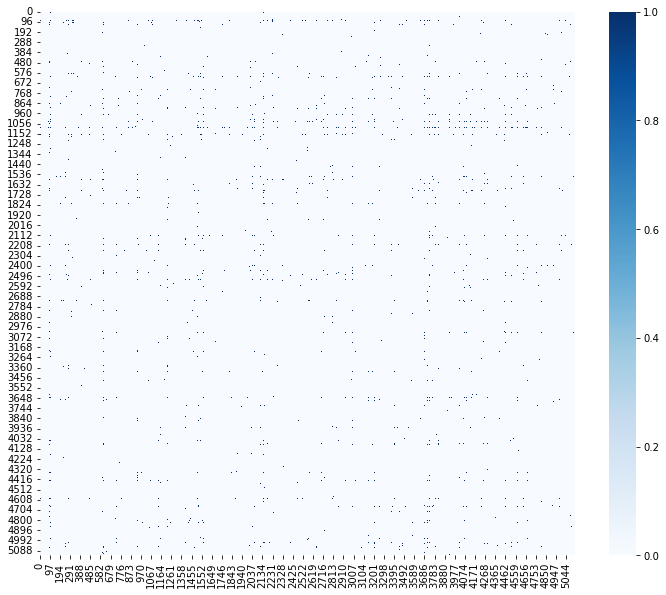

In [11]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = adj_matrix_crs.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

In [12]:
mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1, inplace=True)
uni_cities = mobility_df.copy()
adj_matrix_crs, mobility_df, nodes_df = ns.keep_giant(ns.find_components(adj_matrix_crs, nodes_df), mobility_df)

### Degree distribution

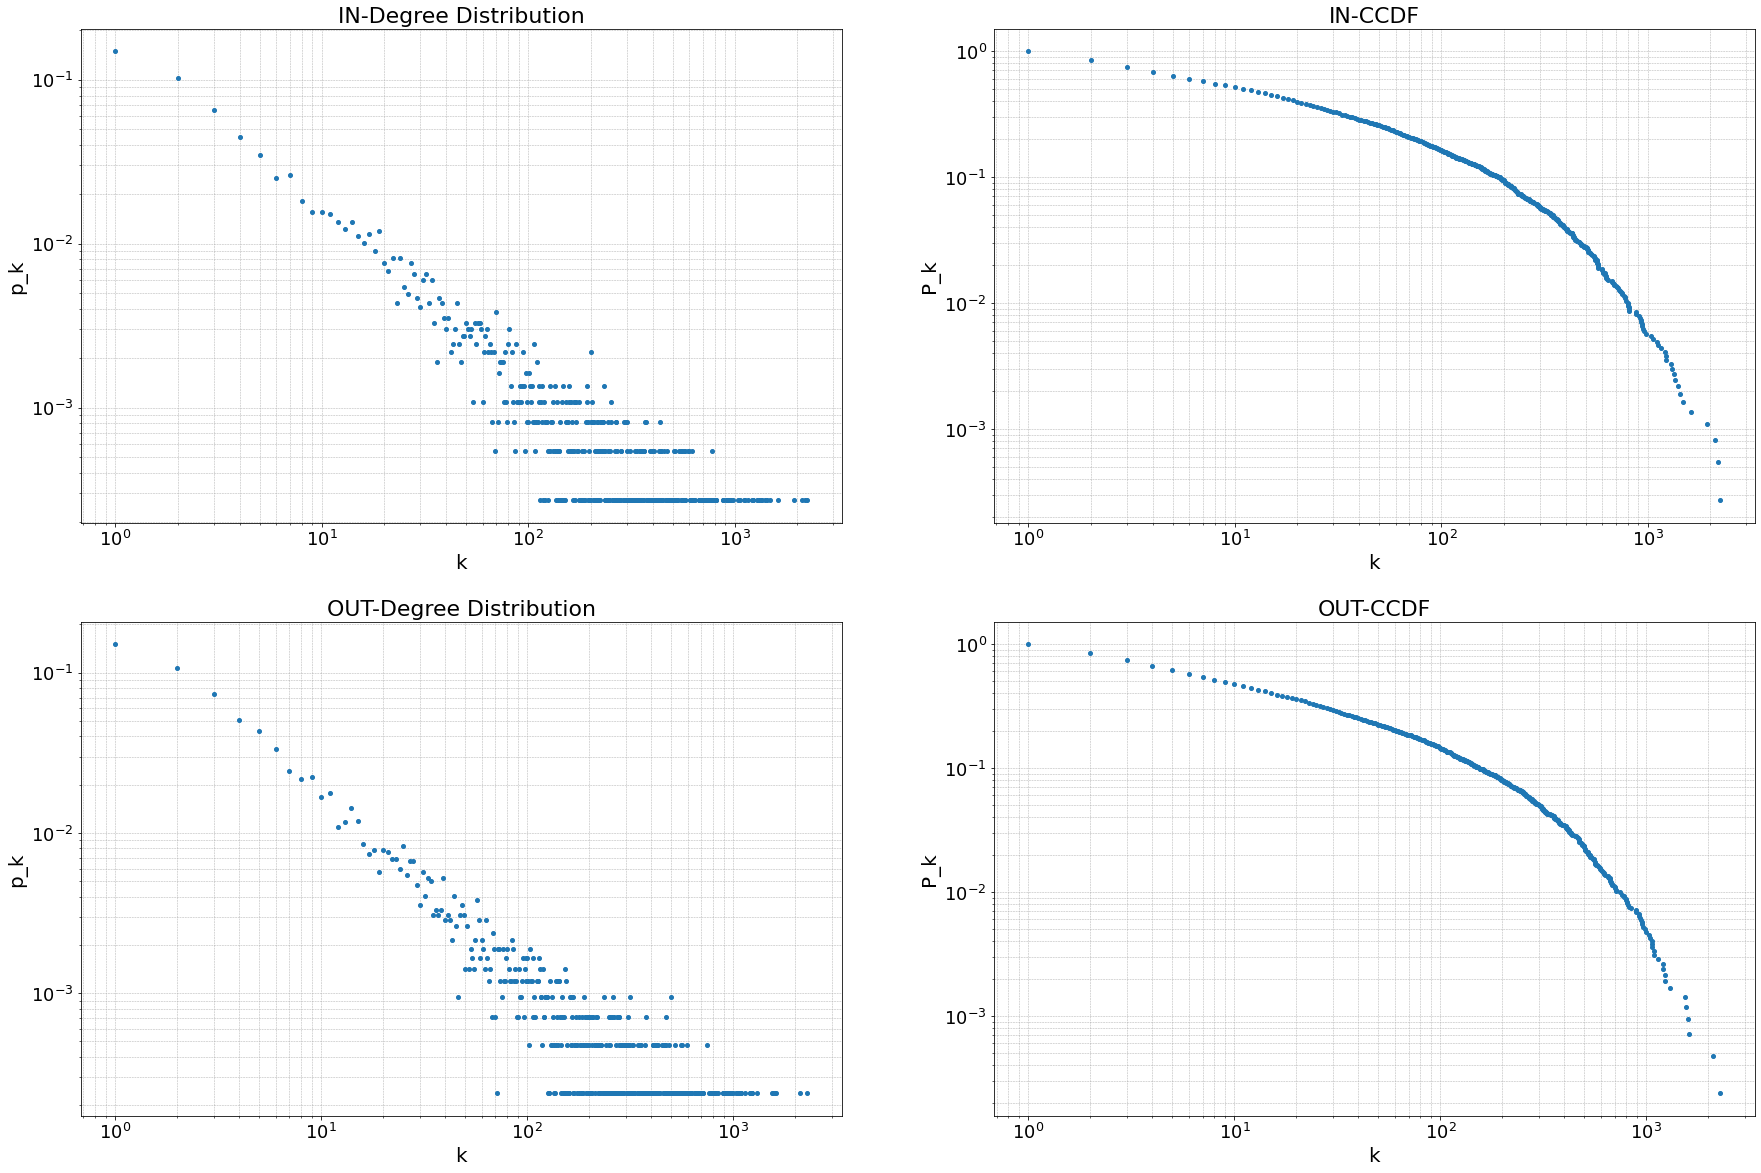

Top 10 for in degree


,Nodes,in degree
245,UNIVERSITAT DE VALENCIA,2238
2740,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2179
690,UNIVERSIDADE DE LISBOA,2118
1091,UNIVERSIDAD DE GRANADA,1931
2003,UNIVERSIDAD COMPLUTENSE DE MADRID,1612
2731,UNIVERZA V LJUBLJANI,1481
93,UNIVERSITAT POLITECNICA DE VALENCIA,1434
1166,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,1405
980,UNIVERSIDAD DE SEVILLA,1350
3712,KATHOLIEKE UNIVERSITEIT LEUVEN,1341


Top 10 for out degree


,Nodes,out degree
2740,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2280
1091,UNIVERSIDAD DE GRANADA,2114
245,UNIVERSITAT DE VALENCIA,1604
2003,UNIVERSIDAD COMPLUTENSE DE MADRID,1590
3370,UNIVERSITA DEGLI STUDI DI PADOVA,1563
882,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,1544
3427,UNIVERSITA DEGLI STUDI DI TORINO,1299
690,UNIVERSIDADE DE LISBOA,1228
3712,KATHOLIEKE UNIVERSITEIT LEUVEN,1225
2282,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,1203


In [13]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### Estimating $\gamma$ 

In [14]:
from collections import Counter
from statistics import mean

d_in = scores['in degree']
d_in = d_in[d_in>0]
d_out = scores['out degree']
d_out = d_out[d_out>0]
kmin = 100
d2_in = d_in[d_in>kmin]
d2_out = d_out[d_out>kmin]

sorted_d = sorted(d_in)
occurrence = Counter(sorted_d)
x_in = list(occurrence.keys())
y_in = list(occurrence.values())
y_in = y_in/np.sum(y_in)

sorted_d = sorted(d_out)
occurrence = Counter(sorted_d)
x_out = list(occurrence.keys())
y_out = list(occurrence.values())
y_out = y_out/np.sum(y_out)

Pk_in = 1 - np.cumsum(y_in)
Pk_in[-1] = 1 
Pk_in = sorted(Pk_in, reverse = True)
Pk_out = 1 - np.cumsum(y_out)
Pk_out[-1] = 1 
Pk_out = sorted(Pk_out, reverse = True)

In [15]:
ga_in = 1 + 1/mean(np.array(np.log(d2_in/kmin)))
ga_out = 1 + 1/mean(np.array(np.log(d2_out/kmin)))
C_in = (ga_in-1)*kmin**(ga_in-1) # normalization condition
C_out = (ga_out-1)*kmin**(ga_out-1)

pos_in = np.argmax(np.array(x_in)>=kmin)
pos_out = np.argmax(np.array(x_out)>=kmin)

P_kmin_in = Pk_in[pos_in] # constant value that shifts the line where the data are placed
pk_in = C_in*P_kmin_in*x_in**-ga_in
Pk_est_in = C_in*P_kmin_in*x_in**(-(ga_in-1))/(ga_in-1) 

P_kmin_out = Pk_out[pos_out] # constant value that shifts the line where the data are placed
pk_out = C_out*P_kmin_out*x_out**-ga_out
Pk_est_out = C_out*P_kmin_out*x_out**(-(ga_out-1))/(ga_out-1) 

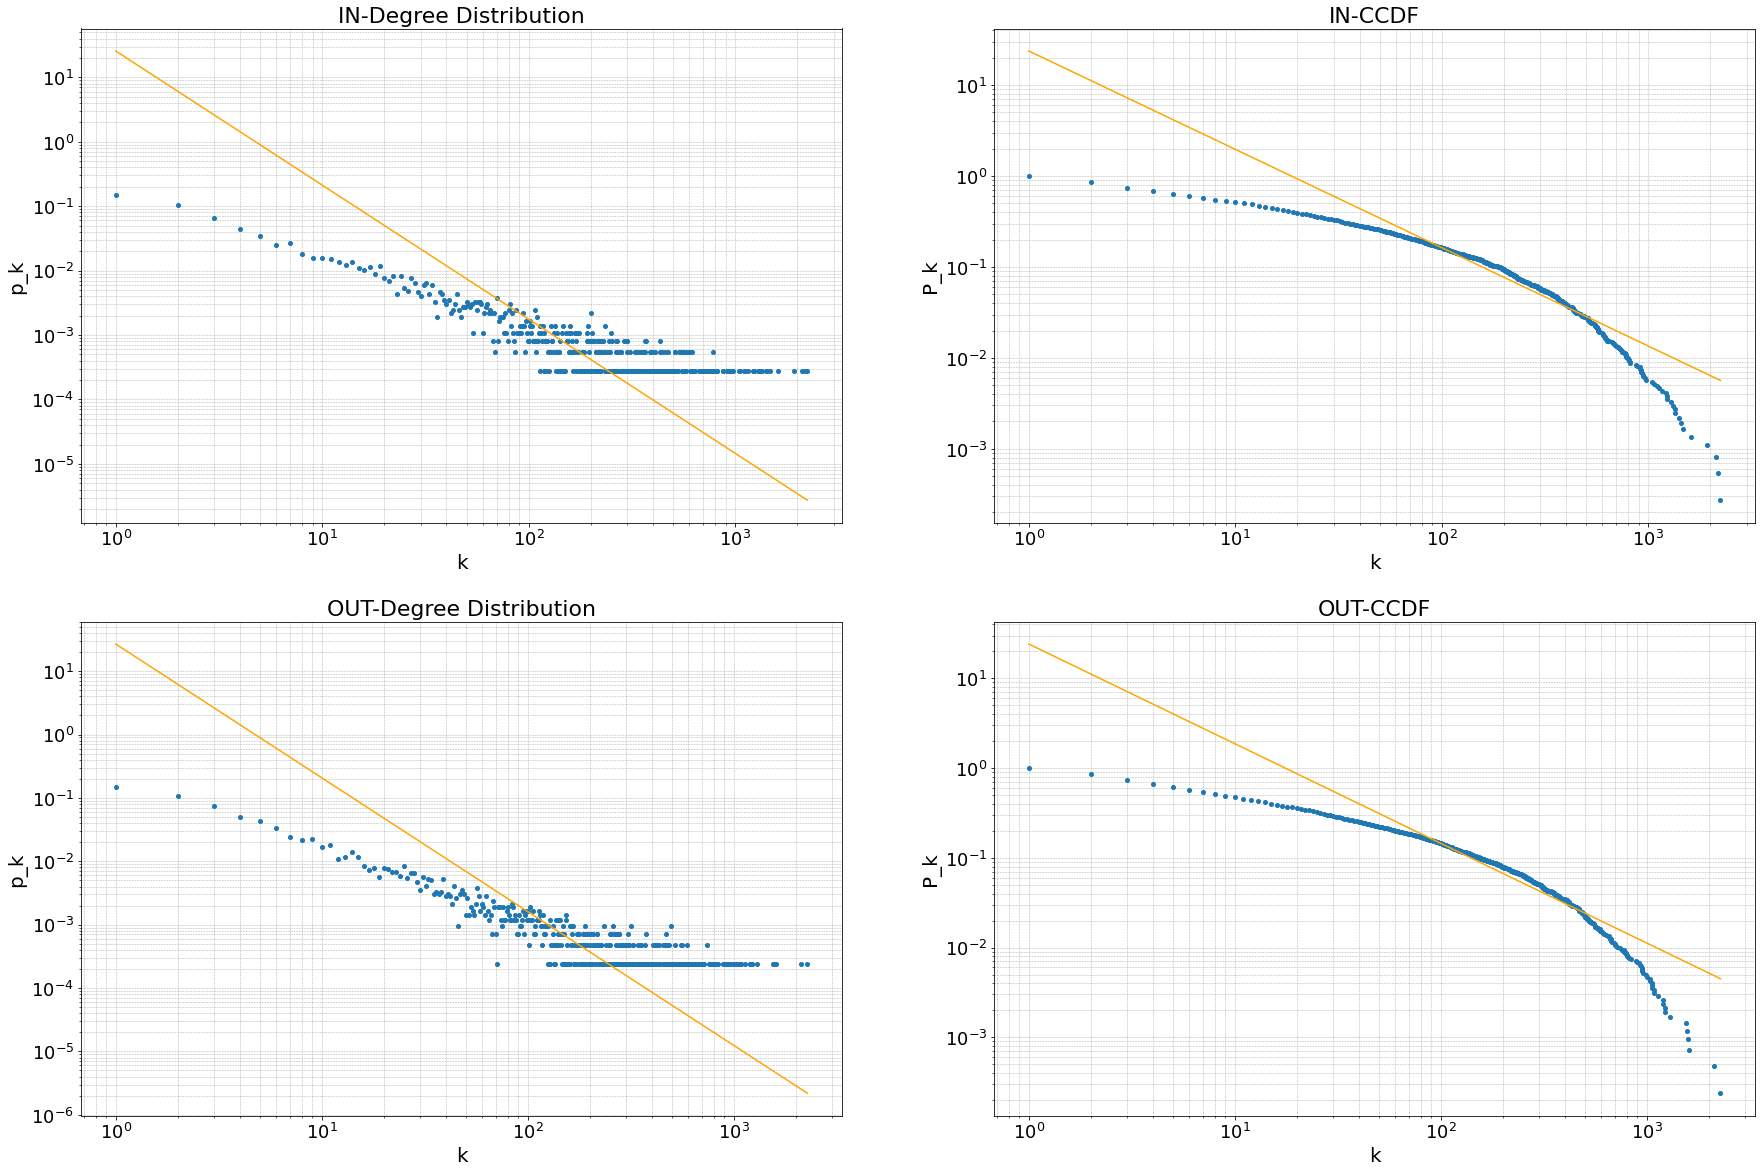

In [16]:
fig, ax = plt.subplots(2, 2, figsize = (30, 20))

def plot_gamma(ax, x, y, title, p, cumulative=False):
    ax.loglog(x, y, 'o', markersize = 4)
    ax.loglog(x, p, color='orange')
    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.set_title(title, size = 22)
    ax.set_xlabel("k", size = 20)
    if cumulative:
        ax.set_ylabel("P_k", size = 20)
    else:
        ax.set_ylabel("p_k", size = 20)
    ax.tick_params(labelsize=18)
    ax.tick_params(labelsize=18)

plot_gamma(ax[0,0], x_in, y_in, "IN-Degree Distribution", pk_in)
plot_gamma(ax[0,1], x_in, Pk_in, "IN-CCDF", Pk_est_in, True)
plot_gamma(ax[1,0], x_out, y_out, "OUT-Degree Distribution", pk_out)
plot_gamma(ax[1,1], x_out, Pk_out, "OUT-CCDF", Pk_est_out, True)
plt.show()

### Estimating $\gamma$ through a linear fit with log binning

In [17]:
# Log binning 
nbins = 20
bins = np.logspace(0, 3.3, nbins)

hist_in = np.histogram(d_in, bins=bins, density=True)
hist_out = np.histogram(d_out, bins=bins, density=True)
logbin_p_k_in = hist_in[0]
logbin_p_k_out = hist_out[0]
middle_bins = np.sqrt( np.delete(bins, 0) * np.delete(bins, nbins-1) )

mask = np.log10(middle_bins) > np.log10(kmin)
x = np.log10( middle_bins[mask] )
y_in = np.log10( logbin_p_k_in[mask] )
y_out = np.log10( logbin_p_k_out[mask] )

# Linear fit
params_in = np.polyfit(x, y_in, deg =1)
params_out = np.polyfit(x, y_out, deg =1)
lin_gamma_in = -params_in[0]
lin_gamma_out = -params_out[0]

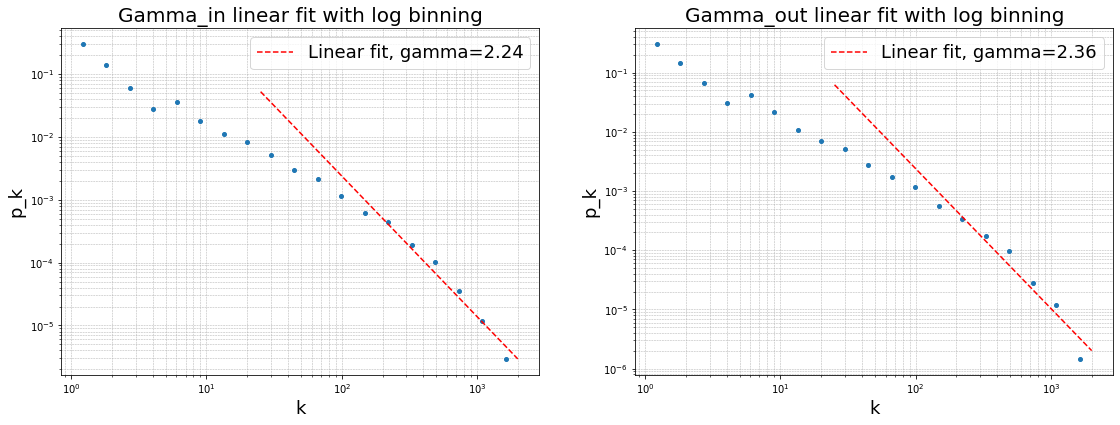

In [18]:
plt.figure(figsize=(60, 60))
plt.subplot(8, 6, 1)
plt.loglog(middle_bins, logbin_p_k_in , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_in linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_in[1])*x2**(-lin_gamma_in) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_in,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.subplot(8, 6, 2)
plt.loglog(middle_bins, logbin_p_k_out , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_out linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_out[1])*x2**(-lin_gamma_out) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_out,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.show()

### HITS (NetworkX)

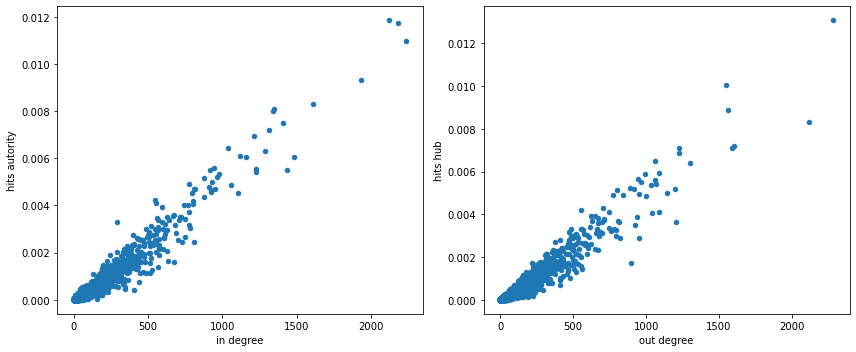

Top 10 for hits hub


,Nodes,hits hub
2740,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.013068
882,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.010048
3370,UNIVERSITA DEGLI STUDI DI PADOVA,0.008881
1091,UNIVERSIDAD DE GRANADA,0.008339
245,UNIVERSITAT DE VALENCIA,0.007203
690,UNIVERSIDADE DE LISBOA,0.007114
2003,UNIVERSIDAD COMPLUTENSE DE MADRID,0.007107
3712,KATHOLIEKE UNIVERSITEIT LEUVEN,0.006883
2131,TECHNISCHE UNIVERSITAET MUENCHEN,0.006487
3427,UNIVERSITA DEGLI STUDI DI TORINO,0.006378


Top 10 for hits autority


,Nodes,hits autority
690,UNIVERSIDADE DE LISBOA,0.011846
2740,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.011721
245,UNIVERSITAT DE VALENCIA,0.010979
1091,UNIVERSIDAD DE GRANADA,0.009306
2003,UNIVERSIDAD COMPLUTENSE DE MADRID,0.008310
980,UNIVERSIDAD DE SEVILLA,0.008109
3712,KATHOLIEKE UNIVERSITEIT LEUVEN,0.008007
1166,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.007508
713,UNIVERZITA KARLOVA,0.007196
1580,UNIVERSITAT DE BARCELONA,0.006963


In [19]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

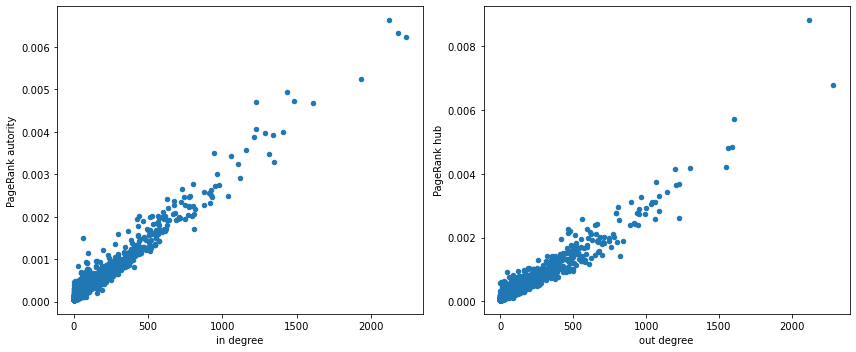

Top 10 for PageRank hub


,Nodes,PageRank hub
1091,UNIVERSIDAD DE GRANADA,0.008810
2740,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006786
245,UNIVERSITAT DE VALENCIA,0.005716
2003,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004823
3370,UNIVERSITA DEGLI STUDI DI PADOVA,0.004807
882,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.004214
3427,UNIVERSITA DEGLI STUDI DI TORINO,0.004182
646,UNIVERSIDAD POLITECNICA DE MADRID,0.004139
2731,UNIVERZA V LJUBLJANI,0.003745
690,UNIVERSIDADE DE LISBOA,0.003693


Top 10 for PageRank autority


,Nodes,PageRank autority
690,UNIVERSIDADE DE LISBOA,0.006626
2740,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006335
245,UNIVERSITAT DE VALENCIA,0.006226
1091,UNIVERSIDAD DE GRANADA,0.005244
93,UNIVERSITAT POLITECNICA DE VALENCIA,0.004949
2731,UNIVERZA V LJUBLJANI,0.004723
1156,POLITECNICO DI MILANO,0.004714
2003,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004670
3370,UNIVERSITA DEGLI STUDI DI PADOVA,0.004074
1166,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.003990


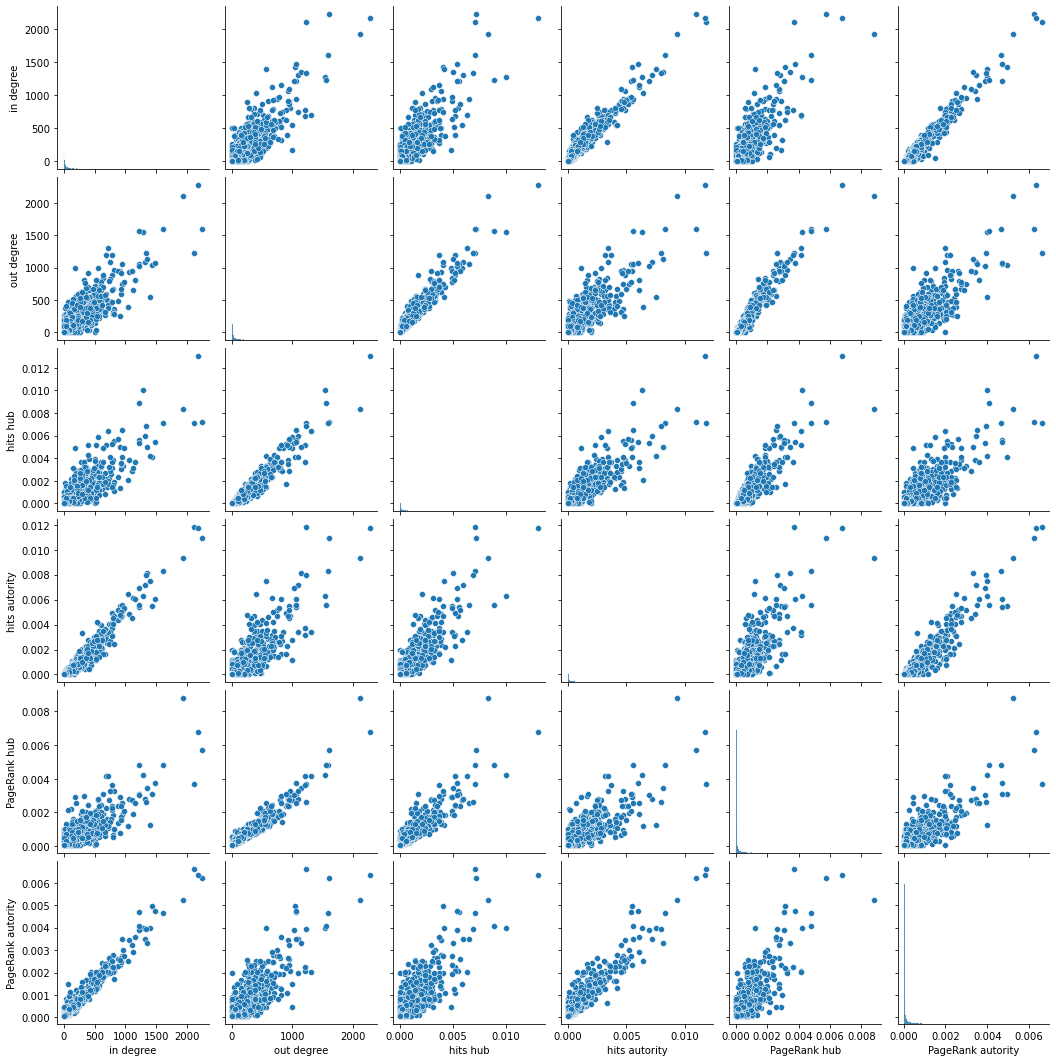

In [20]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')
# ci vuole troppo a farlo
sns.pairplot(scores[['in degree', 'out degree',  'hits hub',
       'hits autority', 'PageRank hub', 'PageRank autority']])
plt.show()
# from IPython.display import Image
# Image('pairplot_score.png',)

### Assortativity

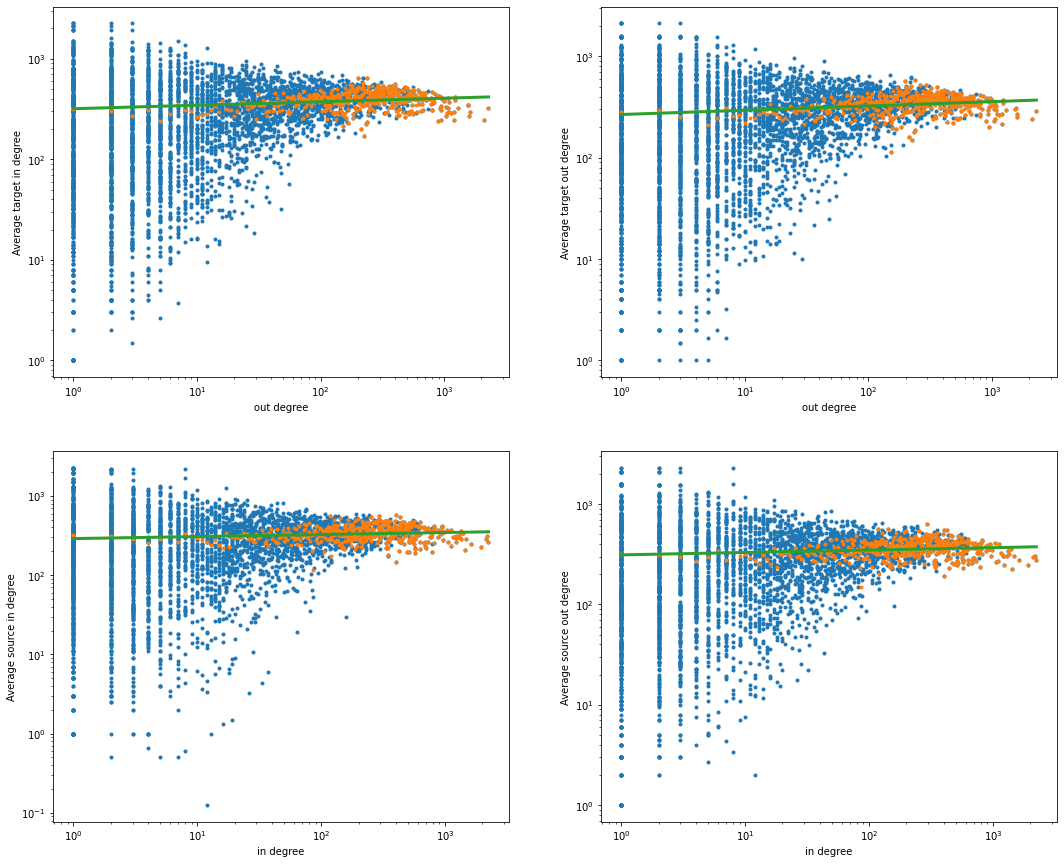

(0.03483226316241359,
 0.0424307695181889,
 0.025510101449321358,
 0.024037335135045804)

In [21]:
edges = mobility_df.copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

## Communities

In [22]:
import networkx as nx

G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
node_comm = nodes_df.copy()
node_comm.drop(columns=['NodeID'], inplace=True)

node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
for i, set in enumerate(p):
    display(node_comm[node_comm['Community']==i])
    
scores['uni_Community'] = node_comm['Community']
# 52 communities. Choose if it makes sense to reduce the number of them 

,Nodes,Community
1,UNIVERSITY OF BELIZE,0
3,TOKAT GAZIOSMANPASA UNIVERSITY,0
4,KOÇ UNIVERSITY,0
5,HOGSKOLEN I MOLDE,0
6,JIANGSU NORMAL UNIVERSITY,0
...,...,...
5091,EKONOMIKAS UN KULTURAS AUGSTSKOLA,0
5092,TERNOPIL IVAN PULUJ NATIONAL UNIVERSITY,0
5094,TALLINNA TERVISHOIU KÕRGKOOL,0
5095,UNIVERSIDADE DE PASSO FUNDO,0


,Nodes,Community
13,UNIVERSITE DE VERSAILLES SAINT-QUENTIN-EN-YVEL...,1
14,KYOTO UNIVERSITY,1
15,PANTEIO PANEPISTIMIO KOINONIKON KAIPOLITIKON E...,1
20,UNIVERSITY OF BRADFORD,1
26,RHODES UNIVERSITY,1
...,...,...
5068,NELSON MANDELA UNIVERSITY,1
5071,CRUZ VERMELHA PORTUGUESA,1
5073,PRAVARA INSTITUTE OF MEDICAL SCIENCES - DEEMED...,1
5093,UNIVERSIDAD NACIONAL DE COLOMBIA,1


,Nodes,Community
2,UNIVERSITÉ 20 AOUT 1955 SKIKDA,2
9,MIDDLE EAST TECHNICAL UNIVERSITY,2
27,INSTITUT RÉGIONAL DU TRAVAIL SOCIAL DE CHAMPAG...,2
30,"UNIVERSITY OF EDUCATION, WINNEBA",2
32,UNIVERSITE DE SIDI BEL-ABBES* DJILLALI LIABES ...,2
...,...,...
5057,VANADZOR STATE UNIVERSITY AFTER H.TUMANYAN FOU...,2
5079,UNIVERSITY OF CHESTER,2
5081,UNIVERSIDAD SURCOLOMBIANA,2
5088,VILLANOVA UNIVERSITY,2


,Nodes,Community
21,ISTITUTO SUPERIORE DI STUDI MUSICALI G. BRICCI...,3
29,KUHNE LOGISTICS UNIVERSITY GMBH,3
62,HOCHSCHULE FÜR MUSIK UND THEATER MÜNCHEN,3
71,CONSERVATORIO SUPERIOR DE MUSICA OSCAR ESPLA,3
77,PADAGOGISCHE HOCHSCHULE WIEN,3
...,...,...
4992,SAINT LOUIS MUSIC CENTER SRL,3
5020,FUNEN ART ACADEMY,3
5030,STAATLICHE HOCHSCHULE FÜR MUSIK TROSSINGEN,3
5076,CONSERVATOIRE NATIONAL SUPÉRIEUR D'ART DRAMATIQUE,3


,Nodes,Community
0,UNIVERSITY OF MASSACHUSETTS,4
25,EVANGELISCHE THEOLOGISCHE FACULTEIT,4
382,ASSOCIATION DES FONDATEURS ET PROTECTEURS DE L...,4
570,"PONTIFICAL UNIVERSITY, ST PATRICK'S COLLEGE MA...",4
587,I-SHOU UNIVERSITY,4
...,...,...
4918,UNIWERSYTET PAPIESKI JANA PAWLA II W KRAKOWIE,4
4934,TRUONG DAI HOC QUOC TE,4
4977,QINGDAO UNIVERSITY,4
4982,LCC INTERNATIONAL UNIVERSITY,4


,Nodes,Community
197,EUROPEAN UNIVERSITY OF MOLDOVA,5
271,PRIDNESTROVIAN SHEVCHENKO STATE UNIVERSITY,5
295,UNIVERSITY OF EUROPEAN ECONOMIC AND POLITICAL ...,5
926,ESCOLA SUPERIOR DE ENFERMAGEM DE LISBOA (ESEL),5
1377,CAPE PENINSULA UNIVERSITY OF TECHNOLOGY,5
...,...,...
4128,"UNIVERSIDAD CENTROAMERICANA ""JOSÉ SIMEÓN CAÑAS""",5
4342,"UNIVERSITY OF GEORGIA RESEARCH FOUNDATION, INC",5
4771,UNIVERSIDAD PUBLICA DE NAVARRA,5
4948,UNIVERSITEIT HASSELT,5


,Nodes,Community
181,BALTIC STATE TECHNICAL UNIVERSITY VOENMEKH NAM...,6
439,UNIVERSITETET I NORDLAND,6
1003,NORD UNIVERSITET,6
1698,CHINA FOREIGN AFFAIRS UNIVERSITY,6
1947,DIPLOMATISCHE AKADEMIE WIEN,6
...,...,...
3771,FEDERAL STATE BUDGETARY EDUCATIONAL INSTITUTIO...,6
3948,YURIY FEDKOVYCH CHERNIVTSI NATIONAL UNIVERSITY,6
4139,CHINA UNIVERSITY OF POLITICAL SCIENCE AND LAW,6
4799,KOREA UNIVERSITY,6


,Nodes,Community
1177,UNIVERSIDAD DE TALCA,7
1345,UNIVERSITE LAVAL,7
1700,"INSTITUT SUPERIEUR DES SCIENCES AGRONOMIQUES, ...",7
1716,CENTRE INTERNATIONAL DES HAUTES ETUDES AGRONOM...,7
1944,LEBANESE UNIVERSITY,7
2014,INSTITUT AGRONOMIQUE ET VETERINAIRE HASSAN II,7
2541,INSTITUT NATIONAL AGRONOMIQUE DE TUNISIE,7
3526,UNIVERSITY OF ALBERTA,7


,Nodes,Community
718,HAKKARI UNIVERSITESI,8
2480,LVIV NATIONAL ACADEMY OF ARTS,8
2817,OMSK STATE UNIVERSITY N.A. F.M.DOSTOEVSKY,8
2834,TIANJIN POLYTECHNIC UNIVERSITY,8
3430,UNIWERSYTET JANA KOCHANOWSKIEGO W KIELCACH,8
4414,SHIBAURA INSTITUTE OF TECHNOLOGY,8
4714,GRIGOL ROBAKIDZE UNIVERSITY,8
4715,YÜZÜNCÜ YIL ÜNIVERSITESI,8


,Nodes,Community
1129,SÁROSPATAKI REFORMÁTUS TEOLÓGIAI AKADÉMIA,9
1581,PROTESTANT THEOLOGICAL INSTITUTE OF CLUJ-NAPOCA,9
1919,FULLER THEOLOGICAL SEMINARY,9
3273,DEBRECENI REFORMÁTUS HITTUDOMÁNYI EGYETEM,9
3748,THEOLOGISCHE UNIVERSITEIT VAN DE GEREFORMEERDE...,9
3755,DET TEOLOGISKE MENIGHETSFAKULTET,9
4412,EVANGÉLIKUS HITTUDOMÁNYI EGYETEM,9
4807,AUGUSTANA-HOCHSCHULE,9


,Nodes,Community
1066,CENTRO INTEGRAL DE FP ILERNA S.L.,10
1408,IES MARIA DE ZAYAS Y SOTOMAYOR,10
2156,LYCÉE DES MÉTIERS DE L'HÔTELLERIE ET DU TOURIS...,10
2221,HIGHER HOTEL INSTITUTE CYPRUS (HHIC),10
2291,SOUTH WEST COLLEGE,10
4361,IES HOTEL ESCUELA,10
4567,CENTRE INTEGRAL DE FP ILERNA S.L.,10


,Nodes,Community
2358,EIA - ENSINO E INVESTIGACAO E ADMINISTRACAO SA,11
2646,INSTITUT ESCOLA DEL TREBALL,11
2883,I.E.S. FERMIN BOUZA BREY,11
3318,LYCEE GENERAL TECHNIQUE GASTON BERGER,11
3397,FONDAZIONE ISTITUTO TECNICO SUPERIORE PER LE N...,11
3718,INSTITUT DE VIC,11
4896,LYCÉE JULES GUESDE,11


,Nodes,Community
435,UNIVERSITE ALQUARAOUIYINE,12
525,FACHHOCHSCHULE COBURG,12
974,INTERNATIONAL CENTRE FOR EDUCATION IN ISLAMIC ...,12
1070,ISLAMIC UNIVERSITY OF APPLIED SCIENCES ROTTERDAM,12
3287,UNIVERSITE EZ-ZITOUNA,12
3754,ISTANBUL SABAHATTIN ZAIM UNIVERSITY,12


,Nodes,Community
526,CZECH REPUBLIC-MINISTRY OF DEFENCE-UNIVERSITY ...,13
2170,UNIVERSITE D'EVRY-VAL D'ESSONNE,13
2340,FEDERAL STATE BUDGETARY EDUCATIONAL INSTITUTIO...,13
2815,WYZSZA SZKOLA BEZPIECZENSTWA Z SIEDZIBA W POZN...,13
4432,AKADEMIA OZBROJENYCH SIL GENERALA MILANA RASTI...,13
5046,WOJSKOWA AKADEMIA TECHNICZNA IM. JAROSLAWA DAB...,13


,Nodes,Community
834,CHIMIKOTECHNOLOGITCHEN I METALURGITCHEN UNIVER...,14
1461,INSTITUTO TECNOLOGICO DE SANTO DOMINGO - INTEC,14
2097,UNIVERSITY OF PATRAS,14
3408,AKADEMIA PEDAGOGIKI SPECJALNEJ IM. MARII GRZEG...,14
3574,TECHNISCHE UNIVERSITAET HAMBURG-HARBURG,14


,Nodes,Community
234,ECOLES DE SAINT-CYR COETQUIDAN,15
2078,ECOLE ROYALE MILITAIRE - KONINKLIJKE MILITAIRE...,15
2283,HELMUT SCHMIDT UNIVERSITAT UNIVERSITAT DER BUN...,15
2559,ACADEMIA TEHNICA MILITARA,15
4109,FORSVARSHOGSKOLAN,15


,Nodes,Community
1399,BREST STATE UNIVERSITY NAMED AFTER A.S. PUSHKI...,16
3391,SIHE I. HORBACHEVSKY TERNOPIL STATE MEDICAL UN...,16
4332,UNIVERZITET ZA TURIZAM I MENAGMENT VO SKOPJE,16
4525,INSTITUTO POLITÉCNICO DE GESTÃO E TECNOLOGIA -...,16
4928,PANSTWOWA SZKOLA WYZSZA IM PAPIEZA JANA PAWLA ...,16


,Nodes,Community
1167,DALIAN NATIONALITIES UNIVERSITY,17
1789,SAINT PETERSBURG ELECTROTECHNICAL UNIVERSITY LETI,17
2640,TAYLOR'S UNIVERSITY MALAYSIA,17
3597,ERHVERVSAKADEMI SJÆLLAND,17
5058,UNIVERSIDAD FINIS TERRAE,17


,Nodes,Community
1311,HAUTE ECOLE EN HAINAUT,18
2411,GROUPE 3IL,18
2563,ASSOCIATION RÉGIONALE POUR LA FORMATION PLURIP...,18
4037,ARFIS OI,18


,Nodes,Community
1962,PANNASASTRA UNIVERSITY OF CAMBODIA,19
2055,DIMITRIE CANTEMIR UNIVERSITY OF TARGU MURES,19
3457,ADNAN MENDERES UNIVERSITESI,19
4645,CHEN XINGRONG,19


,Nodes,Community
3265,ZHEJIANG CHINESE MEDICAL UNIVERSITY,20
3434,GGTU,20
3497,ZHEJIANG UNIVERSITY OF SCIENCE AND TECHNOLOGY,20
4979,UNIVERSITATEA DE VEST VASILE GOLDIS DIN ARAD,20


,Nodes,Community
712,LYCEE DE L'HOTELLERIE ET DU TOURISME GEORGES F...,21
2045,SSML GREGORIO VII,21
2699,LYCEE POLYVALENT GEORGES FRECHE,21


,Nodes,Community
225,MEGATREND UNIVERZITET,22
1910,UMAN NATIONAL UNIVERSITY OF HORTICULTURE,22
2763,MAZOWIECKA UCZELNIA PUBLICZNA W PLOCKU,22


,Nodes,Community
1561,INSTITUT MEDITERRANIA,23
2506,"INSTITUT MINES TELECOM, ECOLE NATIONALE SUPER...",23
2949,HOGSKOLEN I SOROST NORGE,23


,Nodes,Community
386,SAINT PETERSBURG NATIONAL RESEARCH UNIVERSITY ...,24
755,ECOLE NATIONALE SUPÉRIEURE D'ARCHITECTURE DE S...,24
3572,HOCHSCHULE ZITTAU/GOERLITZ,24


,Nodes,Community
1375,MANDALAY TECHNOLOGICAL UNIVERSITY,25
3177,TECHNISCHE HOCHSCHULE GEORG AGRICOLA,25
3864,T.F. GORBACHEV KUZBASS STATE TECHNICAL UNIVERSITY,25


,Nodes,Community
1721,ANOTATI ECCLESIASTIKI AKADEMIA THESSALONIKIS,26
2661,KYIV THEOLOGICAL ACADEMY AND SEMINARY OF UKRAI...,26
3874,RELIGIOUS ORGANIZATION OF HIGHER THEOLOGICAL E...,26


,Nodes,Community
517,IES EL ESCORIAL,27
952,INSTITUTO ENSEÑANZA SECUNDARIA SAN JOSE,27
4051,ASS EUROPEAN BUSINESS SCHOOL,27


,Nodes,Community
219,VYSOKA SKOLA MEDZINARODNEHO PODNIKANIA ISM SLO...,28
1197,PANSTWOWA WYZSZA SZKOLA ZAWODOWA W CHELMIE,28
4536,VYSOKA SKOLA EKONOMIE A MANAGEMENTU OPS,28


,Nodes,Community
1270,NORTHERN MICHIGAN UNIVERSITY,29
2751,SHANGHAI JIAN QIAO UNIVERSITY,29
4831,UNIVERSITATEA DE ARTA SI DESIGN DINCLUJ-NAPOCA,29


,Nodes,Community
504,FEDERAL STATE EDUCATIONAL ESTABLISHMENT OF HIG...,30
2571,FEDERAL STATE BUDGET EDUCATIONAL INSTITUTION O...,30
4835,AGRAREN UNIVERSITET - PLOVDIV,30


,Nodes,Community
2369,FRENCH-VIETNAMESE CENTER FOR MANAGEMENT EDUCATION,31
2897,NATIONAL UNIVERSITY OF CVIL ENGINEERING,31
4931,ECOLE NATIONALE SUPERIEURE DES MINES D'ALES,31


,Nodes,Community
1640,MARIN BARLETI SHA,32
4019,"VISOKA SKOLA ""CEPS - CENTAR ZA POSLOVNE STUDIJ...",32
5017,IES RIBEIRA DO LOURO,32


,Nodes,Community
429,HOCHSCHULE FÜR ÖFFENTLICHE VERWALTUNG KEHL,33
785,UNIVERSITE DES SCIENCES JURIDIQUES ET POLITIQU...,33


,Nodes,Community
524,RIGAS STARPTAUTISKA EKONOMIKAS UN BIZNESA ADMI...,34
2525,ESCA ECOLE DE MANAGEMENT,34


,Nodes,Community
1010,NLA HØGSKOLEN,35
2742,GEORGIAN INSTITUTE OF PUBLIC AFFAIR FOUNDATION,35


,Nodes,Community
1235,SCUOLA SUPERIORE DI STUDI UNIVERSITARI E DI PE...,36
2846,ADDIS ABABA UNIVERSITY,36


,Nodes,Community
230,FONDAZIONE UNICAMPUS SAN PELLEGRINO,37
3232,THE MAXIM GORKY LITERARY INSTITUTE,37


,Nodes,Community
2918,AUTOGRAF,38
3563,FREE UNIVERSITY OF TBILISI,38


,Nodes,Community
3560,KOREA NATIONAL UNIVERSITY OF ARTS,39
3569,HOCHSCHULE OSTWESTFALEN-LIPPE,39


,Nodes,Community
1841,PAVLO TYCHYNA UMAN STATE PEDAGOGICAL UNIVERSITY,40
3654,PANSTWOWA WYZSZA SZKOLA ZAWODOWA IM. HIPOLITA ...,40


,Nodes,Community
1512,TÉLÉCOM SUDPARIS,41
3719,UNIVERSIDAD GALILEO,41


,Nodes,Community
1790,KUBAN STATE UNIVERSITY,42
4040,"SKODA AUTO VYSOKA SKOLA, O.P.S.",42


,Nodes,Community
2574,BISHOP GROSSETESTE UNIVERSITY COLLEGE LINCOLN,43
4351,HOGSKOLEN I HEDMARK,43


,Nodes,Community
2909,AMASYA UNIVERSITESI,44
4450,ESCOLA SUPERIOR DE EDUCAÇÃO DE FAFE,44


,Nodes,Community
3025,"SVEUČILIŠTE/UNIVERZITET ""VITEZ"" VITEZ",45
4529,COLLEGE OF APPLIED SCIENCES LAVOSLAV RUZICKA I...,45


,Nodes,Community
2819,HAUTE ECOLE DE LA PROVINCE DE NAMUR,46
4591,ASSOCIATION DE GESTION DES ECOLES DES SCIENCES...,46


,Nodes,Community
3110,"VISOKA MEDICINSKA SKOLA STRUKOVNIH STUDIJA ""MI...",47
4598,VELEUCILISTE U BJELOVARU,47


,Nodes,Community
3854,LYCEE AMPERE,48
4888,INSTITUT POBLENOU,48


,Nodes,Community
1201,EOTVOS JOZSEF FOISKOLA,49
5070,"FACULTY OF EDUCATION, UNIVERSITY OF KRAGUJEVAC",49


,Nodes,Community
4187,FUNDACION UNIVERSIDAD DE LAS AMERICAS PUEBLA,50


,Nodes,Community
4207,RENMIN UNIVERSITY OF CHINA,51


## Geographical heatmap

In [23]:
temp_df = uni_cities[['target', 'Receiving City']].copy()
temp_df.rename({'target':'source', 'Receiving City':'Sending City'},axis=1, inplace=True)
cities_uni = pd.concat([uni_cities[['source', 'Sending City']], temp_df]).drop_duplicates().reset_index(drop=True)

for index in range(cities_uni.shape[0]):
    city = cities_uni.iat[index,1]
    if city != city.upper():
        cities_uni.iat[index,1] = city.upper()
cities_uni = cities_uni.drop_duplicates().reset_index(drop=True)
cities_uni = cities_uni.drop_duplicates(subset='source').reset_index(drop=True)

# assigning cities to each university in scores
cities_list = []
for u in scores['Nodes']:
    cities_list.append(list(cities_uni.loc[cities_uni['source'] == u, 'Sending City'])[0])

scores_cities = scores.copy()
scores_cities['City'] = cities_list

scores_cities

,Nodes,NodeID_x,in degree,out degree,NodeID_y,hits hub,hits autority,NodeID,PageRank hub,PageRank autority,uni_Community,City
0,UNIVERSITY OF MASSACHUSETTS,0,2,0,0,-0.000000e+00,0.000001,0,0.000045,0.000050,4,AMHERST
1,UNIVERSITY OF BELIZE,1,0,5,1,2.143780e-05,-0.000000,1,0.000063,0.000043,0,BELICE
2,UNIVERSITÉ 20 AOUT 1955 SKIKDA,2,1,12,2,1.077669e-04,0.000017,2,0.000076,0.000045,2,SKIKDA
3,TOKAT GAZIOSMANPASA UNIVERSITY,3,0,64,3,3.964977e-05,-0.000000,3,0.000141,0.000043,0,TOKAT
4,KOÇ UNIVERSITY,4,2,0,4,-0.000000e+00,0.000016,4,0.000045,0.000050,0,TR ISTANBU17
...,...,...,...,...,...,...,...,...,...,...,...,...
5094,TALLINNA TERVISHOIU KÕRGKOOL,5094,29,2,5094,2.007648e-06,0.000058,5094,0.000050,0.000154,0,TALLINN
5095,UNIVERSIDADE DE PASSO FUNDO,5095,0,1,5095,9.711909e-07,-0.000000,5095,0.000048,0.000043,0,"PASSO FUNDO, RIO GRANDE DO SUL"
5096,LIBERA UNIVERSITA DI LINGUE E COMUNICAZIONE,5096,28,106,5096,5.247695e-04,0.000126,5096,0.000316,0.000115,1,MILANO
5097,COOPERATIVA DE ENSINO SUPERIOR DE SERVIÇO SOCIAL,5097,15,2,5097,4.836152e-06,0.000039,5097,0.000051,0.000087,2,SENHORA DA HORA


In [24]:
city_coord = pd.read_csv('worldcities.csv', encoding='utf8')
city_coord.drop(columns=['capital', 'population', 'id', 'iso3', 'country'], inplace=True)
for index in range(city_coord.shape[0]):
    city = city_coord.iat[index,0]
    if city != city.upper():
        city_coord.iat[index,0] = city.upper()
city_coord = city_coord.drop_duplicates().reset_index(drop=True)
scores_cities = pd.merge(left=scores_cities, right=city_coord, how='left', left_on='City', right_on='city')
scores_cities.dropna(subset=['city'], inplace=True)
scores_cities = scores_cities.drop_duplicates(subset='Nodes').reset_index(drop=True)
scores_cities

# some cities are missing like Milano, Torino, Madrid (these are also pretty much important)

,Nodes,NodeID_x,in degree,out degree,NodeID_y,hits hub,hits autority,NodeID,PageRank hub,PageRank autority,uni_Community,City,city,city_ascii,lat,lng,iso2,admin_name
0,UNIVERSITY OF MASSACHUSETTS,0,2,0,0,-0.000000,1.129165e-06,0,0.000045,0.000050,4,AMHERST,AMHERST,Amherst,43.0117,-78.7569,US,New York
1,UNIVERSITÉ 20 AOUT 1955 SKIKDA,2,1,12,2,0.000108,1.689793e-05,2,0.000076,0.000045,2,SKIKDA,SKIKDA,Skikda,36.8667,6.9000,DZ,Skikda
2,TOKAT GAZIOSMANPASA UNIVERSITY,3,0,64,3,0.000040,-0.000000e+00,3,0.000141,0.000043,0,TOKAT,TOKAT,Tokat,40.3097,36.5542,TR,Tokat
3,HOGSKOLEN I MOLDE,5,56,5,5,0.000016,1.570272e-04,5,0.000058,0.000176,0,MOLDE,MOLDE,Molde,62.7333,7.1833,NO,Møre og Romsdal
4,INSTITUT NATIONAL DES SCIENCES APPLIQUEES DE R...,7,38,122,7,0.000473,1.223296e-04,7,0.000237,0.000148,0,RENNES,RENNES,Rennes,48.1147,-1.6794,FR,Bretagne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3519,DHURAKIJ PUNDIT UNIVERSITY,5090,1,0,5090,-0.000000,4.592495e-08,5090,0.000045,0.000058,0,BANGKOK,BANGKOK,Bangkok,13.7500,100.5167,TH,Krung Thep Maha Nakhon
3520,TERNOPIL IVAN PULUJ NATIONAL UNIVERSITY,5092,0,1,5092,0.000002,-0.000000e+00,5092,0.000049,0.000043,0,TERNOPIL,TERNOPIL,Ternopil,49.5667,25.6000,UA,Ternopil’s’ka Oblast’
3521,UNIVERSIDAD NACIONAL DE COLOMBIA,5093,0,5,5093,0.000007,-0.000000e+00,5093,0.000067,0.000043,1,BOGOTA,BOGOTA,Bogota,40.8750,-74.0293,US,New Jersey
3522,TALLINNA TERVISHOIU KÕRGKOOL,5094,29,2,5094,0.000002,5.839851e-05,5094,0.000050,0.000154,0,TALLINN,TALLINN,Tallinn,59.4372,24.7450,EE,Harjumaa


Importing geographic data also for countries

In [25]:
import geopandas as gpd
import pycountry as pc #library used for translating country codes from iso3 to iso2 standard

geo_df = gpd.read_file('countries.geojson')

def replace_iso2(alpha):
    try:
        return pc.countries.get(alpha_3=alpha).alpha_2
    except:
        return alpha
    
geo_df['iso2_code']= (np.array(list(map(lambda x: replace_iso2(x), geo_df['ISO_A3']))))

geo_df.columns = ['country', 'country_code', 'geometry', 'iso2_code']

# in geo_df United Kingdom has code GB, so we have to change it manually
geo_df.loc[geo_df['country'] == 'United Kingdom', 'iso2_code'] = 'UK'
geo_df.loc[geo_df['country'] == 'Greece', 'iso2_code'] = 'EL'
geo_df.loc[geo_df['country'] == 'Kosovo', 'iso2_code'] = 'XK'
geo_df.loc[geo_df['country'] == 'Czech Republic', 'country'] = 'Czechia'
geo_df.loc[geo_df['country'] == 'Republic of Serbia', 'country'] = 'Serbia'

# merge geometries with our dataframe
geo_scores = pd.merge(left=scores_cities, right=geo_df[['iso2_code', 'geometry']], how='left', 
                      left_on='iso2', right_on='iso2_code')
geo_scores = geo_scores[['Nodes', 'PageRank hub', 'PageRank autority', 'City', 'lat', 'lng',
                         'iso2', 'geometry', 'uni_Community']]

Dividing universities by their country community

In [37]:
import networkx as nx

### 1 create the network of countries only
country_df = c_df[c_df[c_df.columns[10]]=='Learner']
country_df = country_df.loc[:, c_df.columns[np.array((14, 17, 20))]]
country_df.dropna(how='any', inplace=True)

# c_nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[0]]), set(country_df.loc[:, country_df.columns[1]]))))
c_nodes = np.array(list(pd.concat([country_df.loc[:, country_df.columns[0]], country_df.loc[:, country_df.columns[1]]]).drop_duplicates()))
country_df.dropna(how='any', inplace=True)

c_node_position = {}
for i, name in enumerate(c_nodes):
    c_node_position[name] = i
country_nodes= pd.DataFrame({'Nodes': c_nodes})
country_df['SendId'] = (np.array(list(map(lambda x: c_node_position[x], country_df['Sending Country Code']))))
country_df['RecId'] = (np.array(list(map(lambda x: c_node_position[x], country_df['Receiving Country Code']))))
# Adjacency matrix
country_serie = country_df.groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
c_adj_matrix = sparse.csr_matrix((val.flatten(), (row, col)), shape=(c_nodes.size, c_nodes.size))

### 2 countries community
G_country = nx.convert_matrix.from_scipy_sparse_matrix(c_adj_matrix)
p_c = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_country)
country_comm = country_nodes.copy()

country_comm['Community']=np.zeros(len(country_comm.index),dtype='int8')
for i, set in enumerate(p_c):
    for element in set:
        country_comm.iat[element, 1]=i
for i, set in enumerate(p_c):
    display(country_comm[country_comm['Community']==i])

geo_scores = pd.merge(left=geo_scores, right=country_comm, how='left', left_on='iso2', right_on='Nodes')

,Nodes,Community
1,AT,0
4,KR,0
9,CA,0
16,US,0
17,UG,0
...,...,...
125,IR,0
133,BW,0
137,BT,0
143,VE,0


,Nodes,Community
2,UA,1
3,RU,1
5,RS,1
7,IL,1
8,PS,1
...,...,...
120,AF,1
122,SD,1
126,RW,1
134,LY,1


,Nodes,Community
6,ET,2
11,AU,2
12,NZ,2
21,NP,2
30,UZ,2
...,...,...
136,AO,2
138,IQ,2
139,MR,2
141,SR,2


,Nodes,Community
0,PT,3
23,IN,3
26,TN,3
34,JO,3
58,TZ,3
...,...,...
112,NO,3
115,TL,3
116,LA,3
117,SE,3


,Nodes,Community
24,BE,4
61,CM,4
104,LI,4
127,CD,4
128,NI,4
146,CH,4


C:\Users\gianm\AppData\Local\Temp/ipykernel_9544/3224942390.py:37: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Nodes_x'} in the result is deprecated and will raise a MergeError in a future version.
  geo_scores = pd.merge(left=geo_scores, right=country_comm, how='left', left_on='iso2', right_on='Nodes')


In [38]:
eu_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']

def replace_iso3166(alpha):
    try:
        return pc.countries.get(name=alpha).alpha_2
    except:
        return alpha
    
eu_countries_iso2 = list(map(lambda x: replace_iso3166(x), eu_countries))

geo_scores = geo_scores[geo_scores['iso2'].isin(eu_countries_iso2)]


(-74.63098303979987, 62.068097363800064, -61.22412688574994, 87.53171621275013)

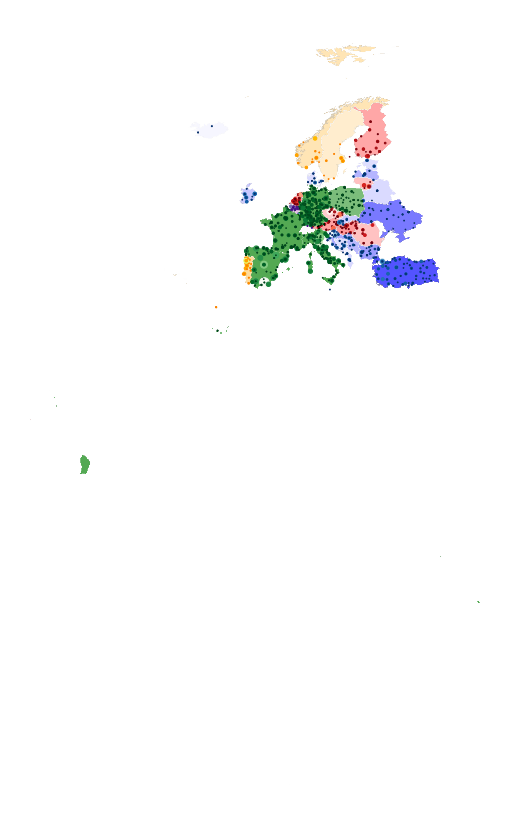

In [39]:
colors = ['red', 'blue', 'green', 'orange', 'purple']
cmaps = ['Reds_r', 'Blues_r', 'Greens_r', 'Wistia_r', 'Purples_r']

fig, ax = plt.subplots(figsize=(20,15))

for c in range(5):
    temp_df = geo_scores[geo_scores['Community'] == c].copy()
    temp_df = gpd.GeoDataFrame(temp_df, geometry = 'geometry')
    temp_df.plot(ax=ax, edgecolor='0.5', linewidth=0.3, color=colors[c], alpha=0.01)
    ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, c=temp_df['PageRank hub'],
                  cmap=cmaps[c])
ax.axis('off')

In [45]:
import networkx as nx

### 1 create the network of countries only
country_df = c_df[c_df[c_df.columns[10]]=='Learner']
country_df = country_df.loc[:, c_df.columns[np.array((14, 17, 20))]]
country_df.dropna(how='any', inplace=True)

# c_nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[0]]), set(country_df.loc[:, country_df.columns[1]]))))
c_nodes = np.array(list(pd.concat([country_df.loc[:, country_df.columns[0]], country_df.loc[:, country_df.columns[1]]]).drop_duplicates()))
country_df.dropna(how='any', inplace=True)

c_node_position = {}
for i, name in enumerate(c_nodes):
    c_node_position[name] = i
country_nodes= pd.DataFrame({'Nodes': c_nodes})
country_df['SendId'] = (np.array(list(map(lambda x: c_node_position[x], country_df['Sending Country Code']))))
country_df['RecId'] = (np.array(list(map(lambda x: c_node_position[x], country_df['Receiving Country Code']))))
# Adjacency matrix
country_serie = country_df.groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
c_adj_matrix = sparse.csr_matrix((val.flatten(), (row, col)), shape=(c_nodes.size, c_nodes.size))

### 2 countries community
G_country = nx.convert_matrix.from_scipy_sparse_matrix(c_adj_matrix, create_using=nx.DiGraph)
p_c = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_country)
country_comm = country_nodes.copy()

country_comm['Community']=np.zeros(len(country_comm.index),dtype='int8')
for i, set in enumerate(p_c):
    for element in set:
        country_comm.iat[element, 1]=i
for i, set in enumerate(p_c):
    display(country_comm[country_comm['Community']==i])

geo_scores = pd.merge(left=geo_scores, right=country_comm, how='left', left_on='iso2', right_on='Nodes')

,Nodes,Community
1,AT,0
6,ET,0
30,UZ,0
33,CU,0
51,CR,0
...,...,...
132,GA,0
134,LY,0
135,HN,0
136,AO,0


,Nodes,Community
8,PS,1
10,TH,1
14,AL,1
17,UG,1
21,NP,1
...,...,...
123,NG,1
128,NI,1
140,PA,1
141,SR,1


,Nodes,Community
2,UA,2
3,RU,2
5,RS,2
12,NZ,2
13,ME,2
...,...,...
109,MK,2
110,MT,2
118,SK,2
119,TR,2


,Nodes,Community
11,AU,3
35,VN,3
38,KZ,3
40,LB,3
50,MY,3
...,...,...
111,NL,3
116,LA,3
117,SE,3
126,RW,3


,Nodes,Community
4,KR,4
7,IL,4
9,CA,4
16,US,4
18,ID,4
...,...,...
98,HU,4
99,IE,4
114,UK,4
133,BW,4


,Nodes,Community
0,PT,5
25,DZ,5
26,TN,5
31,KH,5
32,MA,5
...,...,...
130,MG,5
138,IQ,5
142,MO,5
143,VE,5


C:\Users\gianm\AppData\Local\Temp/ipykernel_9544/1658415126.py:37: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Nodes_x'} in the result is deprecated and will raise a MergeError in a future version.
  geo_scores = pd.merge(left=geo_scores, right=country_comm, how='left', left_on='iso2', right_on='Nodes')


Focus on european countries

In [46]:
eu_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']

def replace_iso3166(alpha):
    try:
        return pc.countries.get(name=alpha).alpha_2
    except:
        return alpha
    
eu_countries_iso2 = list(map(lambda x: replace_iso3166(x), eu_countries))

geo_scores = geo_scores[geo_scores['iso2'].isin(eu_countries_iso2)]


(-74.63098303979987, 62.068097363800064, -61.22412688574994, 87.53171621275013)

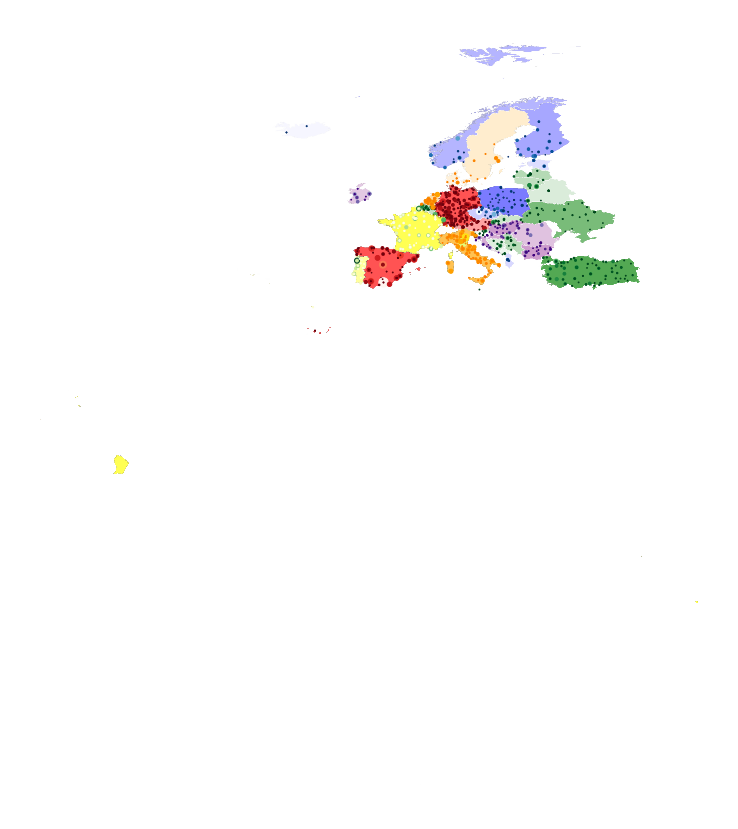

In [47]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']
cmaps = ['Reds_r', 'Blues_r', 'Greens_r', 'Wistia_r', 'Purples_r', 'YlGn']

fig, ax = plt.subplots(figsize=(20,15))

for c in range(6):
    temp_df = geo_scores[geo_scores['Community'] == c].copy()
    temp_df = gpd.GeoDataFrame(temp_df, geometry = 'geometry')
    temp_df.plot(ax=ax, edgecolor='0.5', linewidth=0.3, color=colors[c], alpha=0.01)
    ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, c=temp_df['PageRank hub'],
                  cmap=cmaps[c])
ax.axis('off')

### Universities communities geographic plot

(-74.63098303979987, 62.068097363800064, -61.22412688574994, 87.53171621275013)

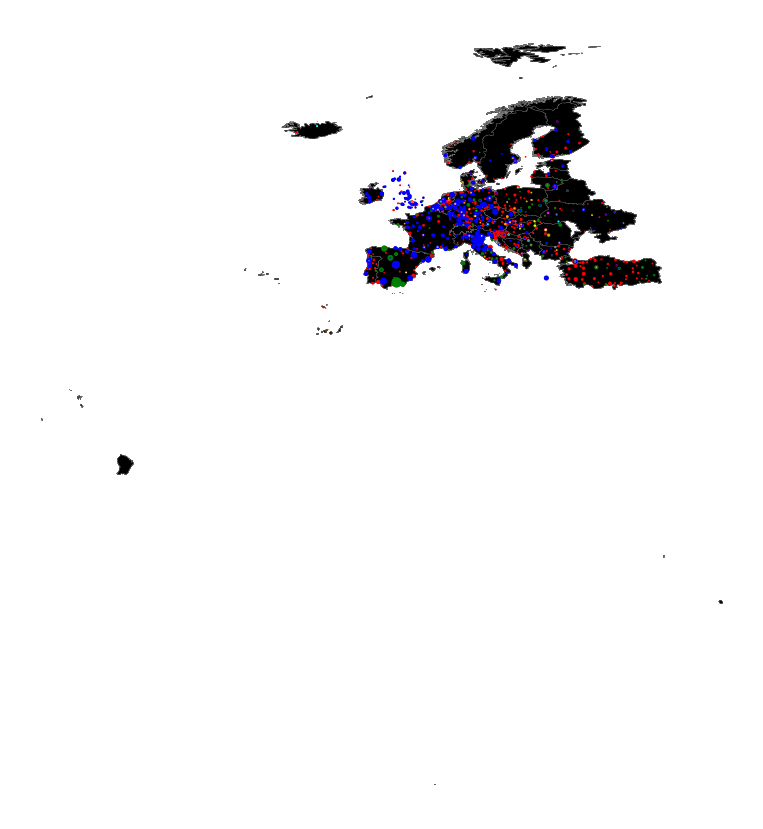

In [ ]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'grey', 'gold', 'aqua', 'fuchsia', 'pink', 'yellow', 'salmon', 
          'khaki', 'brown', 'lime', 'skyblue', 'peachpuff', 'ivory', 'powderblue', 'rosybrown', 'royalblue', 
          'saddlebrown', 'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue',
          'slategray', 'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet',
          'wheat', 'white', 'whitesmoke', 'yellow', 'yellowgreen', 'lightgreen', 'lightgray', 'lightpink', 'lightsalmon', 
          'lightseagreen', 'lightskyblue', 'lightslategray']

geo_plt = geo_scores.copy()
# dropping all communities containing number of universities lower or equal than 3
for c in range(max(geo_plt['uni_Community'])):
    if geo_plt[geo_plt['uni_Community'] == c].shape[0] <= 2:
        geo_plt = geo_plt[geo_plt['uni_Community'] != c]

fig, ax = plt.subplots(figsize=(20,15))

geo_plt = gpd.GeoDataFrame(geo_plt, geometry='geometry')
geo_plt.plot(ax=ax, edgecolor='0.5', linewidth=0.3, color='0')

# sns.scatterplot(x='lng', y='lat', data=geo_plt, hue='uni_Community', legend=False, ax=ax, size=geo_plt['PageRank hub']*10**4)
# ax.scatter(x=geo_plt['lng'], y=geo_plt['lat'], s=geo_plt['PageRank hub']*10**4, c=geo_plt['uni_Community'], cmap='jet')

for c in list(geo_plt['uni_Community'].unique()):
    temp_df = geo_plt[geo_plt['uni_Community'] == c].copy()
    temp_df = gpd.GeoDataFrame(temp_df, geometry = 'geometry')
    # ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, c=temp_df['uni_Community'], cmap='Pastel1')
    # ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, cmap='Pastel1')
    # ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, c=temp_df['uni_Community'])
    ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, color=colors[c])
ax.axis('off')

### Robustness

In [ ]:
#attack: removing hubs first
nodes_byhub = scores.sort_values('PageRank hub', ascending=False)['NodeID']
indices = list(nodes_byhub)
uni_df = mobility_df.copy()
GC_frac_a = [1]
for node in indices:
    uni_df = uni_df.loc[(uni_df['sourceID'] != node) & (uni_df['targetID'] != node)]
    temp_serie = uni_df.groupby(['sourceID', 'targetID']).sum()
    row = np.array(temp_serie.index.get_level_values(1).tolist())
    col = np.array(temp_serie.index.get_level_values(0).tolist())
    val = temp_serie.values
    temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
    GC_frac_a.append(ns.fraction_in_giant(temp_adj))


In [ ]:
#random node removal
import random
#10 by 10, with average over 10 trials each time
intervals = list(range(10, len(nodes_byhub+1), 10))
uni_df = mobility_df.copy()
GC_frac_r = [1]
for i in intervals:
    i_GC_frac = []
    for j in range(10):
        removed = random.sample(indices, i)
        temp_df = uni_df.loc[~(uni_df['sourceID'].isin(removed) | (uni_df['targetID'].isin(removed)))]
        temp_serie = temp_df.groupby(['sourceID', 'targetID']).sum()
        row = np.array(temp_serie.index.get_level_values(1).tolist())
        col = np.array(temp_serie.index.get_level_values(0).tolist())
        val = temp_serie.values
        temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
        i_GC_frac.append(ns.fraction_in_giant(temp_adj))
    GC_frac_r.append(sum(i_GC_frac)/10)

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot([i/len(nodes_byhub) for i in range(len(nodes_byhub)+1)], GC_frac_a, label='Targeted attack')
plt.plot([0]+[i/(len(intervals)*10) for i in intervals], GC_frac_r, 'r', label='Random node removal')
plt.plot([0,1], [1,0], 'g', label='linear reference')
plt.xlabel('Fraction of nodes in the giant component', size=14)
plt.ylabel('Fraction of removed nodes', size=14)
plt.title('Robustness', size=20)
plt.legend(fontsize=16)
plt.show()